<h1> Predicting User Knowledge Level Using KNN Classification</h1>
<h2> DSCI 100: Group 38 Final Project </h2>

<b>Introduction: </b>

- <u>Background: </u>
- <u>Dataset description: </u>
    - Dataset title:  <b> <a href="https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling"> User Knowledge Modeling Data Set </a> </b>
    - The dataset we are using is the “User Knowledge Modelling Dataset” from the UCI Machine Learning Repository in which the population consists of 403 undergraduate students in the Department of Electrical Education of Gazi University in the 2009 semester. 
    - Dataset terminology:
    
        <b>STG</b> - The degree of study time for goal object materials

        <b>SCG</b> - The degree of repetition number of user for goal object materials

        <b>STR</b> - The degree of study time of user for related objects with goal object

        <b>LPR</b> - The exam performance of user for related objects with goal object

        <b>PEG</b> - The exam performance of user for goal objects

        <b>UNS</b> - The knowledge level of user
    
- <u>Objectives</u>: From the raw dataset, the target value is UNS and is classified through input values: STG, SCG, STR, LPR, and PEG. Our objective is to determine the category of UNS assigned to the user based on PEG (we will discuss later why we only choose this variable as the predictor) with k-NN classification. The target value is the knowledge level of students/ ‘users’ about the subject of Electrical DC Machines in which its features is PEG and its categories are:
    - Very low
    - Low
    - Middle
    - High
    
    <br>

<b> Methods & Results: 

- <u>Preliminary exploratory data analysis: </u>

Firstly, we loaded in the packages that were needed, and set the seed so that everything is reproducible for the data analysis. </i>

In [1]:
library(tidyverse)
library(readxl)
library(digest)
library(dplyr)
library(repr)
library(tidymodels)
library(GGally)
library(themis)
options(repr.matrix.max.rows = 6)

set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in library(themis): there is no package called ‘themis’


<br>

We loaded the data into R by downloading the file, where we then read the training dataset. Then we selected all the variable columns from the data and mutated UNS as a factor. <b>There was no need to wrangle the data into tidy format since it was already provided as such. </b> Each row is a single observation, each column is a single variable and each value is a single cell.
    
Now we need to choose the suitable predictor(s) for our prediction. We wanted to use the ggpairs function to find the correlations between all the variables and UNS, so that we can choose the ones with relatively strong correlations with UNS as predictor(s). But we noticed that UNS was not in the numeric form, so we assigned each UNS category a numeric value, from 1 to 4, representing the lowest level to the highest level. 

Notice below we used c(1,4,2,3) instead of normal ordering because the first four rows of the UNS column in the training dataset are "very_low, high, low, middle". They are not from the lowest level to the highest level as we wanted. If we use the normal ordering (1:4), then "High" level would be assigned the number 2, "low" level would be assigned the number 3, and "middle" level would be assigned the number 2. That is why we needed to assign the categories as 1, 4, 2, and 3.

In [2]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
              "user_modeling_data.xls")        #loads data from the original source on the web 

original_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (the training data)
                     select(STG : UNS)
head(original_training,10)

whole_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (the training data)
                     select(STG : UNS)%>%              #select columns from STG to UNS
                     mutate(UNS = c(1,4,2,3)[as_factor(UNS)])      #change the categorical data of the UNS column into numeric form in specific order
head(whole_training,10)    # take a look at the first ten rows of the edited dataset

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.00,0.00,0.00,0.00,1
0.08,0.08,0.10,0.24,0.90,4
0.06,0.06,0.05,0.25,0.33,2
0.10,0.10,0.15,0.65,0.30,3
0.08,0.08,0.08,0.98,0.24,2
0.09,0.15,0.40,0.10,0.66,3
0.10,0.10,0.43,0.29,0.56,3
0.15,0.02,0.34,0.40,0.01,1
0.20,0.14,0.35,0.72,0.25,2


Now we can see from the table above that all the four categories in the UNS column are assigned a number corresponding to the data point's knowledge level. So now we are able to use the ggpairs function to visualize the correlations between all variables with UNS.

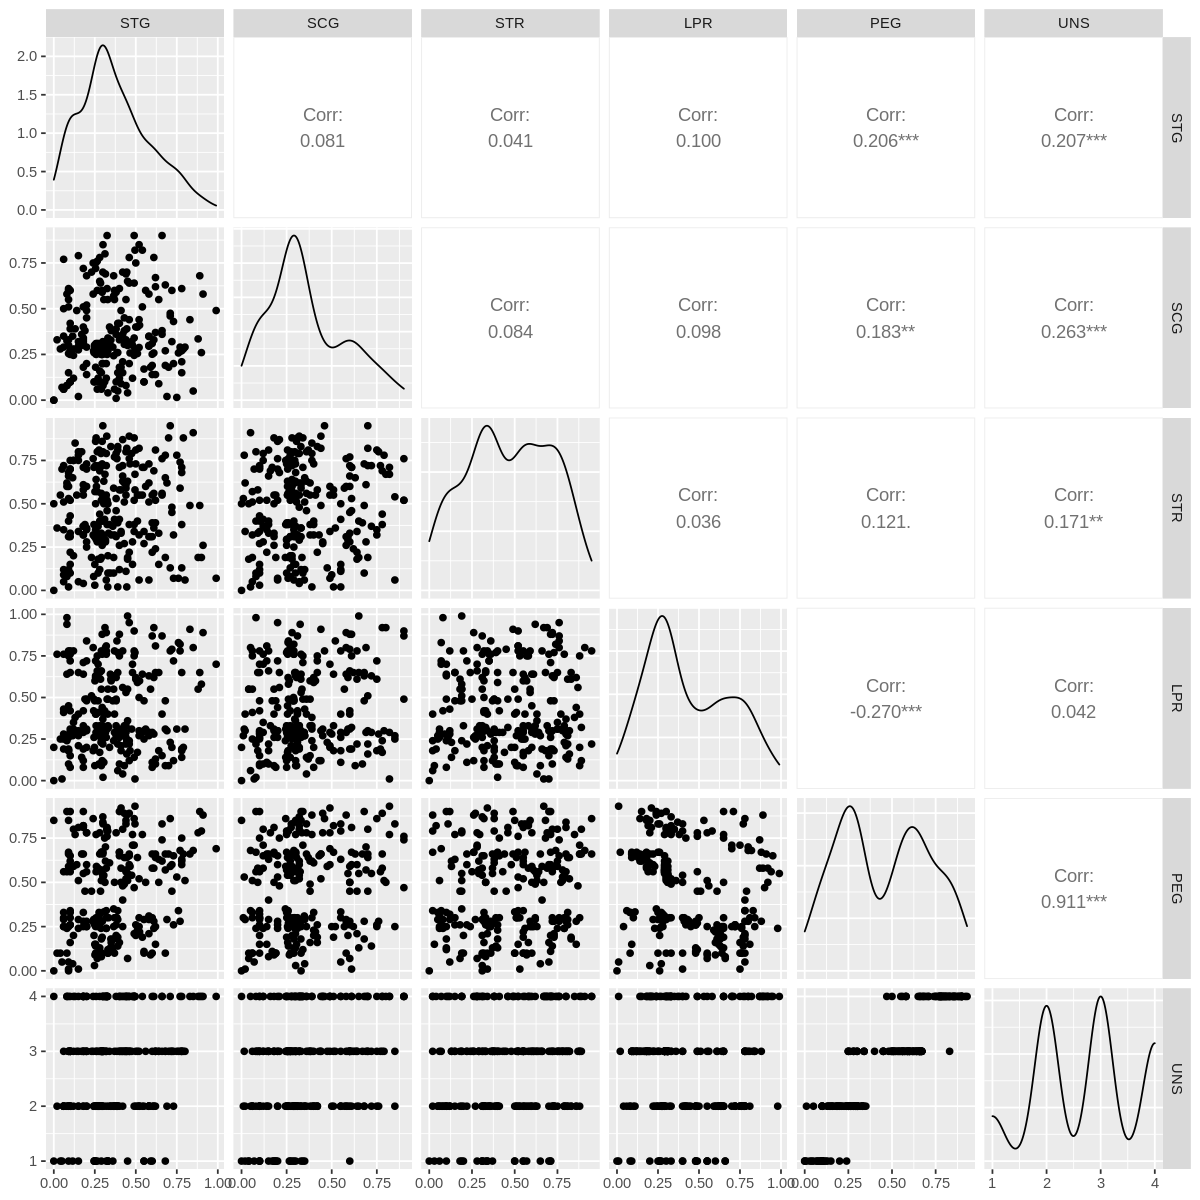

In [95]:
ggpairs(whole_training)

<br>
We can see from the above plot that only PEG has a relatively strong correlation with UNS, at a value of 0.911. This is actually a very strong positive correlation. So we chose PEG as the only predictor, as all the other predictors have a very low correlation value.

<br>

Now we can just select the PEG and UNS columns for both training data and testing data from the original dataset. Since we have chosen the predictor, we no longer need to keep the UNS column in a numeric form. Notice that we renamed one of the values of the UNS column in the testing data to make all the categories have the same name. (The testing data represents the lowest level as "Very Low", but the training data uses "very_low" to represent the lowest level.) If we don't do this, the accuracy of our prediction would be severely affected.

In [10]:
# create the training data
dataset_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file (which consists of the training data)
                     select(PEG,UNS)%>%              #select only predictor and target variable columns
                     mutate(UNS = as_factor(UNS))   # change the UNS column into factor form
head(dataset_training,10)       # take a look at the first 10 rows of the training data

# create the testing data
dataset_testing <- read_excel('user_modeling_data.xls', sheet = 3)%>%     #only read the third sheet from the file (which consists of the testing data)
                     select(PEG,UNS)%>%             #select only predictor and target variable columns
                     mutate(UNS = ifelse(UNS == "Very Low", "very_low", UNS))%>%   # make all the values in UNS column same for training and testing data
                     mutate(UNS = as_factor(UNS))         # change the UNS column into factor form
head(dataset_testing,10)    # take a look at the first 10 rows of the testing data

New names:
* `` -> ...7
* `` -> ...8



PEG,UNS
<dbl>,<fct>
0.00,very_low
0.90,High
0.33,Low
0.30,Middle
0.24,Low
0.66,Middle
0.56,Middle
0.01,very_low
0.25,Low


New names:
* `` -> ...7
* `` -> ...8



PEG,UNS
<dbl>,<fct>
0.05,very_low
0.14,Low
0.85,High
0.85,High
0.90,High
0.30,Low
0.50,Middle
0.15,Low
0.80,High


Here we reordered the categories of the UNS column for the testing data to match the training data, so that the trained model can later make classifications on the testing data.

In [11]:
#makes the factor levels of the training and testing data the same, originally was different
dataset_training$UNS <- ordered(dataset_training$UNS, levels = c("very_low","Low", "Middle", "High")) 
dataset_testing$UNS <- ordered(dataset_testing$UNS, levels = c("very_low","Low", "Middle", "High")) 

<br>

By making a table, we can see the distribution of each status in the training data in regards to their counts and percentages. </i>

In [5]:
num_UNS <- dataset_training %>%
           group_by(UNS) %>%        # group by the UNS column
           summarise(count = n(),             #calculate the number of observations for each status of UNS, dplyr since R was confused on which library to use
                     percentage = n() / nrow(dataset_training) *100)    #calculates the percentage of each UNS category
num_UNS

`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<ord>,<int>,<dbl>
very_low,24,9.302326
Low,83,32.170543
Middle,88,34.108527
High,63,24.418605


We concluded there is no missing data in the training data. </b>

In [6]:
nrow(dataset_training%>%filter(is.na(UNS)))   # find the number of rows with missing data in UNS column
nrow(dataset_training%>%filter(is.na(PEG)))   # find the number of rows with missing data in PEG column

[1] 0

[1] 0

<br>
Through R, we also calculated the average PEG score for the training data to be 0.46

In [7]:
PEGavg <- dataset_training %>%
          summarize(PEGavg = mean(PEG))   #calculate the mean PEG score in the training set
PEGavg

PEGavg
<dbl>
0.4585388


<br>

- <u>Visualization relevant for exploratory data analysis related to the planned analysis:</u>

Lastly, we drew a bar plot to visualize the distribution of PEG (the exam performance of user for goal objects) over UNS (the knowledge level of user).

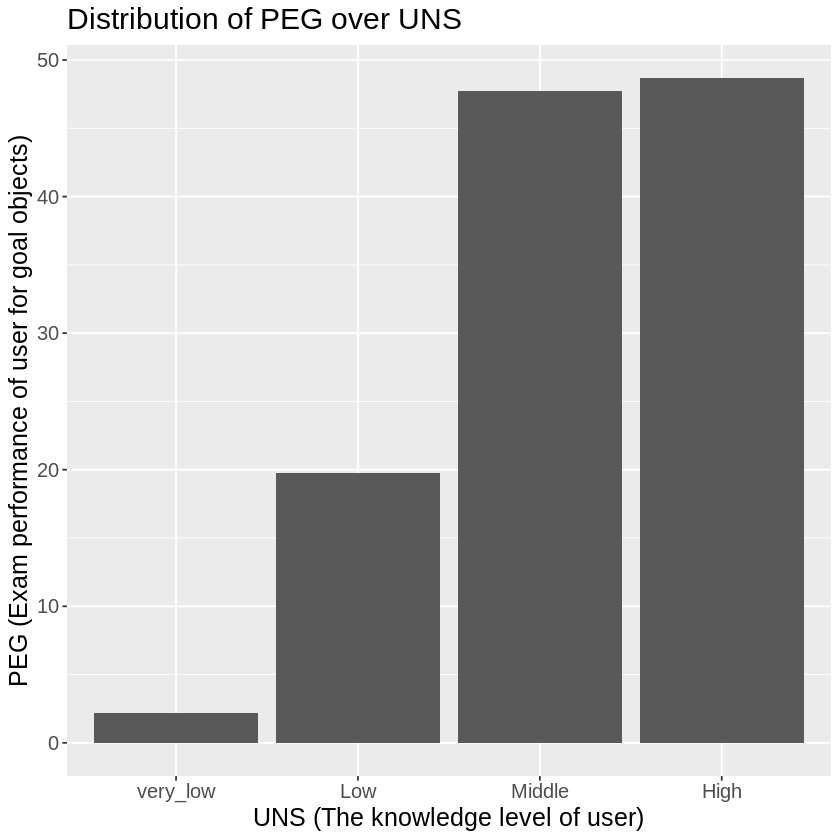

In [12]:
plot <- dataset_training %>%
         ggplot(aes(x = UNS, y = PEG)) + geom_bar(stat = "identity") + 
         labs(x = "UNS (The knowledge level of user)" , 
              y = "PEG (Exam performance of user for goal objects)") + 
         theme(text = element_text(size = 15))+
         ggtitle("Distribution of PEG over UNS")
plot

We can see from the plot that there are more users with increasing knowledge level of users. Most of the users have a middle to high level of knowledge, and the number of users with very low knowledge level is quite small. In other words, the distribution of each level is uneven. So we are planning to balance these four classes before doing the predictions.

<br>

- <u>Data analysis: </u>

We used cross validation to find the k value which gives us the highest accuracy. We can see from both the line plot and the first row of the table that K should be 11, since the models  gives us the highest prediction accuracy at 85.44%.

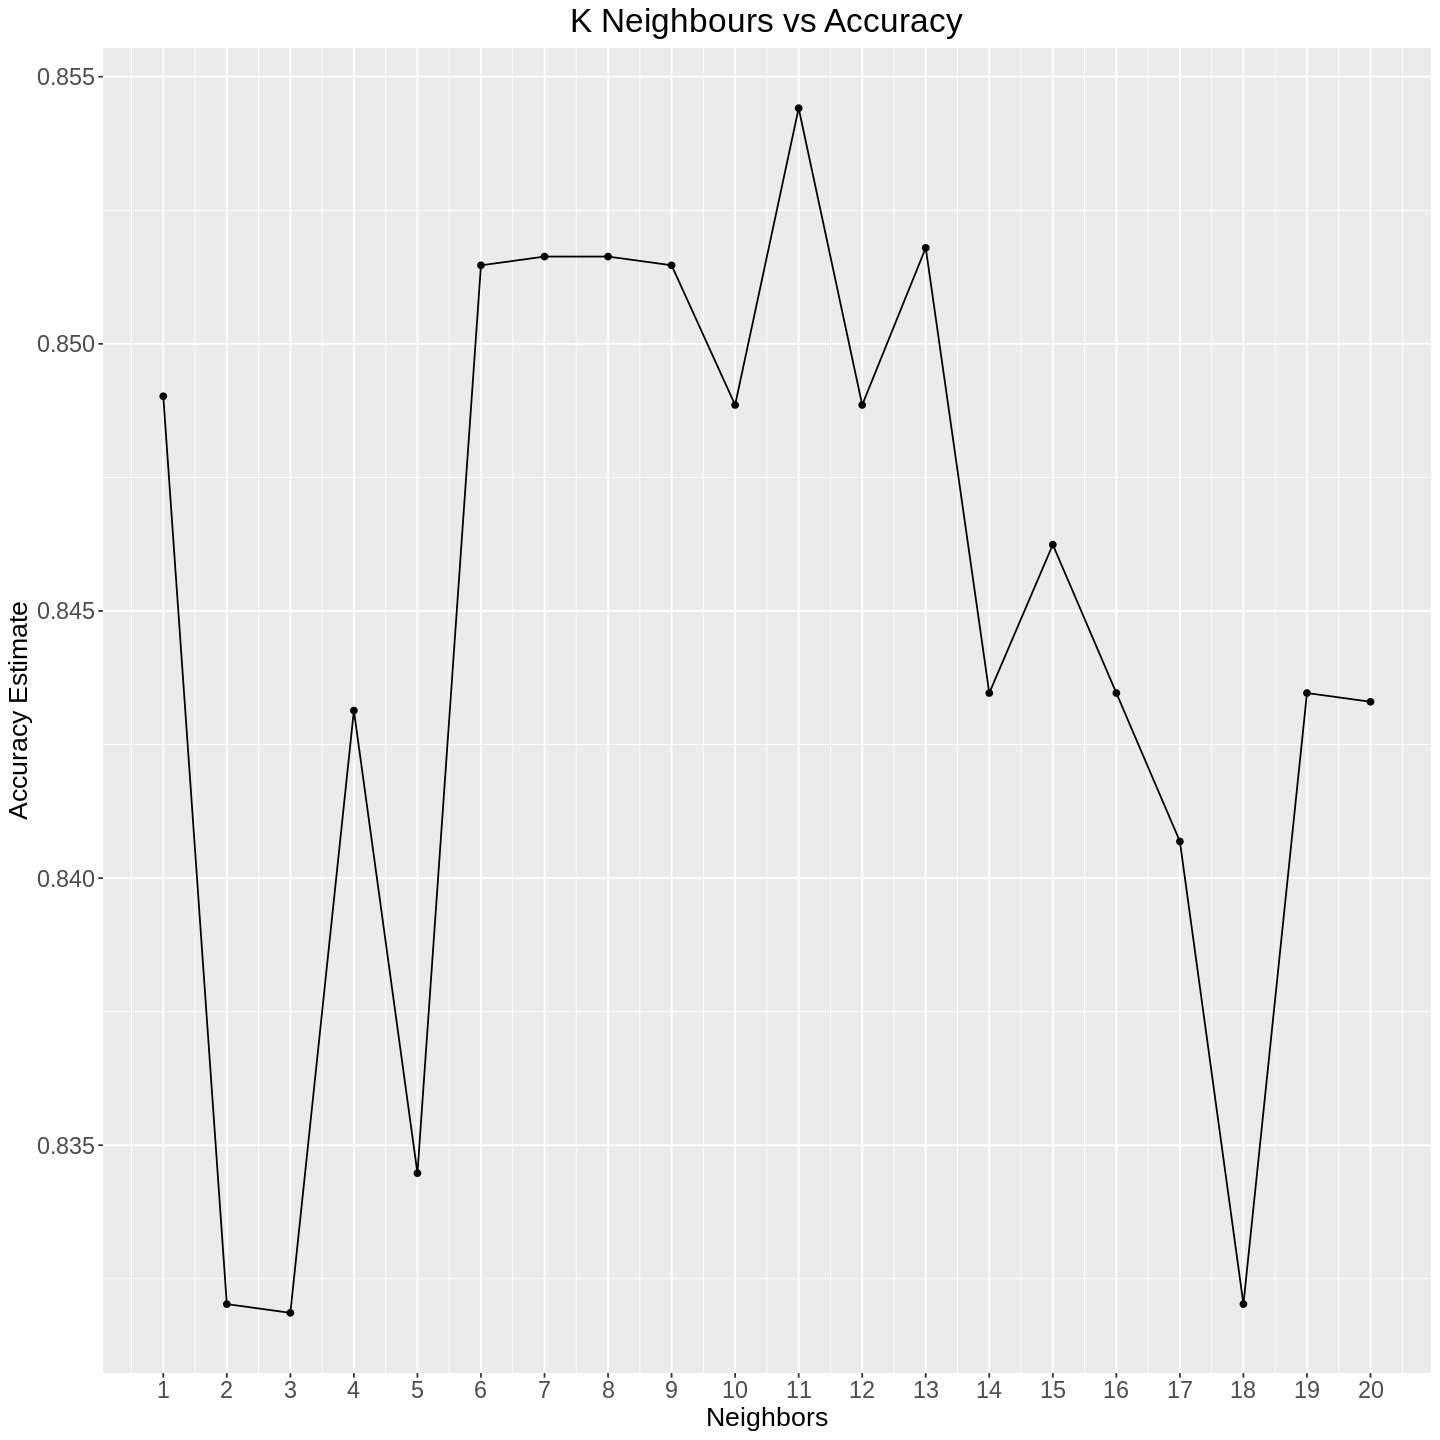

In [32]:
# Find the k value that results in the model having the highest accuracy using cross validation
set.seed(9999)

ups_recipe <- recipe(UNS ~ PEG, data = dataset_training) %>%
              step_upsample(UNS, over_ratio = 1, skip = FALSE) %>%  # adds "fake data points" so that each UNS category has the same number of data points
              prep()
dataset_training_2 <- bake(ups_recipe, dataset_training)

vfold <- vfold_cv(dataset_training_2, v = 5, strata = UNS)   # seperate the data into five random groups

recipe <- recipe(UNS ~ PEG, data = dataset_training_2) %>%   # selected our target variable to be UNS and predictor variable to be PEG
                step_scale(all_predictors()) %>%  
                step_center(all_predictors())  # scaling and centering the predictor variable so that each variable is worth the same

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%  #tuning the K value
             set_engine("kknn") %>%      #tells R that we're using the K-nearest neighbors algorithm for our model
             set_mode("classification")  #tells R that we're using classification for our model    

wkflw <- workflow() %>%                              #creates a workflow
             add_recipe(recipe) %>%                  #adds the recipe into the workflow
             add_model(knn_spec)                     #adds the model into the workflow

gridvals <- tibble(neighbors = seq(from = 1, to = 20))   #creates the list of k values we are going to test

results <- wkflw  %>%
           tune_grid(resamples = vfold, grid = gridvals)  %>%
           collect_metrics() %>%          
           filter(.metric == "accuracy")%>%    #filters out only the rows with the accuracy metric               
           arrange(desc(mean))                 #arranges the rows in descending order of accuracy

accuracy_vs_k <- ggplot(results, aes(x = neighbors, y = mean)) +     #graphs a K vs accuracy scatterplot (to represent which K value maximizes the model's accuracy)
                 geom_point() + geom_line() +                        #specifies that each point in the graph will have a dot and lines that connects each dot together
                 labs(x = "Neighbors", y = "Accuracy Estimate") +    #gives the x and y axis titles
                 scale_x_continuous(breaks = seq(0, 20, by = 1)) +   #makes it easier to match each accuracy point in the graph with its k value
                 ggtitle("K Neighbours vs Accuracy") +                #gives the graph a title
                 theme(axis.title.x = element_text(size = 16),       #makes all the labels on the graph bigger
                       axis.text.x = element_text(size = 14),
                       axis.text.y = element_text(size = 14),
                       axis.title.y = element_text(size = 16),
                      plot.title = element_text(size = 20, hjust = 0.5))

accuracy_vs_k

kmin <- results %>%           #find the k value with highest accuracy
        slice(1) %>%          #slices the first row of the dataframe to get the row with the highest accuracy (since the dataframe was arranged by accuracy in descending order)
        pull(neighbors)       #pulls the number of neighbors in the neighbors column 

Now that we have calculated the most suitable K value for the model, we just plugged it in and ran the classifier.

In [29]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%      # plug in the best k value that we found above
              set_engine("kknn") %>%      
              set_mode("classification")

knn_fit <- workflow() %>%      
           add_recipe(recipe) %>%             #adds the same recipe above
           add_model(knn_spec_2) %>%          #adds the new model with the best k-value that we found above
           fit(data = dataset_training_2)       #fit the training data

predictions <- knn_fit %>%                   #fits the workflow
               predict(dataset_testing) %>%  #predicts the UNS value  for each observation in the testing data
               bind_cols(dataset_testing)    #puts the column with all the predictions into the testing dataframe


summary <- predictions %>%
            metrics(truth = "UNS", estimate = ".pred_class") %>%  #determines the accuracy (and other metrics) based on each testing set observation's predicted UNS value and actual UNS value
           filter(.metric == "accuracy")%>%                       #filters out all the rows with the accuracy metric since that is the only thing we need
           select(.estimate)                                      #selects the accuracy value
summary

.estimate
<dbl>
0.862069


A confusion matrix is helpful here, as it is able to produce a table that shows the table of predicted UNS categories compared to the actual UNS categories of each test data's observation. We would read it diagonally, from the top left number to the bottom right number, each number representing the number of correct predictions for each UNS category. 

To the left and/or right of each row, we can see the number of incorrect predictions the model made, and what category the model incorrectly classified the observation as.


We can see that the model predicted 23 very_low observations correctly, 42 low observations correctly, 25 middle observations correctly, and all 35 high observations correctly.

In [16]:
conf_mat <- predictions %>%          
            conf_mat(truth = UNS, estimate = .pred_class) #creates a confusion matrix so that we can see how many predictions for each category the model predicted correctly
conf_mat

          Truth
Prediction very_low Low Middle High
  very_low       23   3      0    0
  Low             3  42      9    0
  Middle          0   1     25    4
  High            0   0      0   35

<br>

- <u>Visualization of the analysis: </u>

We decided to visualize the result of applying the trained classification model to the testing set of data using a bar plot, since we believe it is the best plot possible to represent the results of the data analysis with, accounting for ease of readability.

Each separate bar represents each UNS category, ranging from very_low to High, and the length of each bar corresponds to the total number of predictions within each category. Each bar is actually a stack of two bars, represented by two colours, red for the number of correct predictions and blue for the number of incorrect predictions. There is also a number label within each stacked bar that tells the audience the number of correct or incorrect predictions for each UNS category.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,correct_predictions,incorrect_predictions,total_predictions
<fct>,<int>,<int>,<int>
very_low,23,3,26
Low,42,4,46
Middle,25,9,34
High,35,4,39


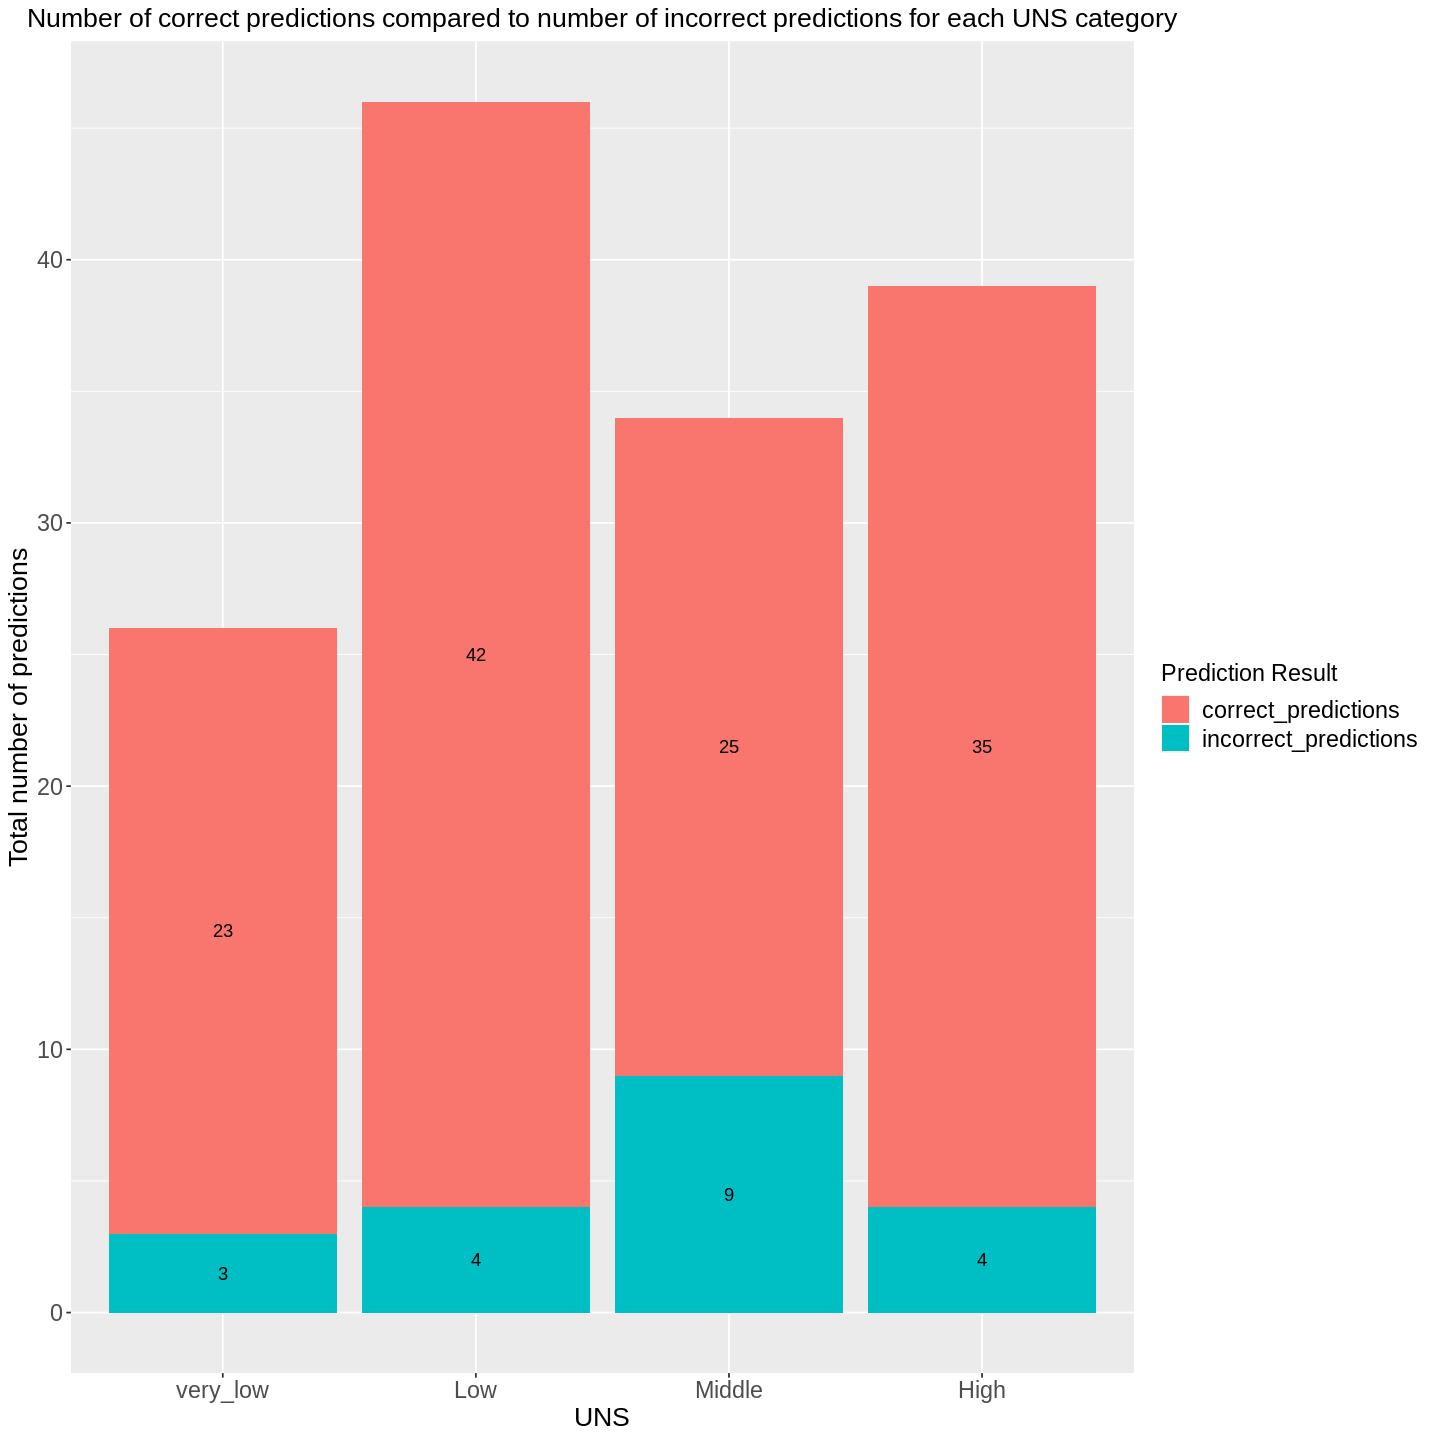

In [41]:
pred <- select(predictions, .pred_class) %>% unlist #unlists each column in the results dataframe so that they can be compared to each other 
                                                    #when determining the number of correct / incorrect predictions
truth <- select(predictions, UNS) %>% unlist
results <- bind_cols(.pred_class = pred, UNS = truth) #binds the two unlisted columns to each other again

correct_predictions <- results %>%             #calculates number of correct predictions (when prediction and truth matches each other)
    filter(.pred_class == UNS) %>%
    group_by(UNS) %>%
    summarise(correct_predictions = n()) %>%
    select(-UNS)                               #removes UNS column so that when we bind the three dfs together there won't be duplicate UNS columns

total_predictions <- results %>%              #calculates total number of predictions 
    group_by(UNS) %>%
    summarise(total_predictions = n())

incorrect_predictions <- results %>%          #calculates number of incorrect predictions (when prediction and truth doesn't match each other)
    filter(.pred_class != UNS) %>%
    group_by(UNS) %>%
    summarise(incorrect_predictions = n()) %>%
    select(-UNS)                             #removes UNS column so that when we bind the three dfs together there won't be duplicate UNS columns

prediction_stats <- bind_cols(correct_predictions, incorrect_predictions, total_predictions) %>% #binds all the dataframe columns together into one single dataframe
    select(UNS, correct_predictions, incorrect_predictions, total_predictions) #makes all the columns "in order" (for ease of readability)
prediction_stats

prediction_stats1 <- prediction_stats %>% 
  select(-total_predictions) %>%
  gather(key = predict_result, value = total_predictions, correct_predictions, incorrect_predictions) #so that fill portion of bargraph can distinguish between correct and incorrect 

options(repr.plot.width = 12, repr.plot.height = 12) # increases size of graph for ease of readability

results_graph <- ggplot(prediction_stats1, aes(x = UNS, y = total_predictions, fill = predict_result)) +  #specifies the columns and df we want the plot to use
    geom_bar(stat = "identity", position = "stack") +                                                     #tells R that we want a stacked bar plot
    labs(x = "UNS Category", y = "Total number of predictions", fill = "Prediction Result") +             #labels the axes and the label 
    geom_text(aes(label = total_predictions), position = position_stack(vjust = 0.5)) +                   #adds the number of each correct/incorrect prediction to each stacked bar
    theme(                                                                                                #increases the size of the plot titles and labels
        axis.title.x = element_text(size = 16),
        axis.text.x = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14),
        axis.text.y = element_text(size = 14), 
        axis.title.y = element_text(size = 16),
        plot.title = element_text(size = 16, hjust = 0.5)) +
        ggtitle("Number of correct predictions compared to number of incorrect predictions for each UNS category") #gives the plot a suitable title
                   
results_graph    

<b> Discussion:

<b> Rerferences: